In [1]:
%pylab inline

import sklearn
import pandas as pd
import seaborn as sns
import arrow

%config InlineBackend.figure_formats = ['retina']
sns.set_style("white")

for lib in (sklearn, np, sns): # seaborn should be .9+ and sklearn .20+
    print(f'{lib.__name__} Version: {lib.__version__}')

Populating the interactive namespace from numpy and matplotlib
sklearn Version: 0.23.2
numpy Version: 1.19.4
seaborn Version: 0.11.0


Theoretical complexity is one thing, but what about empirical complexity? Let's look at the models we might use for classification and see how they do on large datasets.

This is a short lesson meant to get you thinking about *real world, practical* complexity.

In [2]:
import keras # we're just using this to grab the dataset for now
from sklearn import preprocessing

# We're going to need bigger data!

In order to see important differences between models, we'll want to look at them as they handle datasets that are much bigger than what we've used so far in class.

In order to do that, we'll use the full MNIST dataset ([more info](http://yann.lecun.com/exdb/mnist/)). This classic dataset contains 70,000 images of hand written digits. Each image is 28x28 pixels. Just like we saw in the KNN digits demo, we'll perform image recognition by flattening each image so that each of the 784 pixels are treated like a feature.

In total, this gives us about 60MB of data. It may not sound like much, but you'll see this amount cause trouble for several of the algorithms we've discussed.

In [3]:
# Load in the data and measure its size 

(x, y), (x_test, y_test) = keras.datasets.mnist.load_data()

mb = (x.size + x_test.size + y.size + y_test.size)/1e6

print(f"dataset size: {mb}MB")

dataset size: 54.95MB


In [4]:
# Reshape each observation to be 784 features instead of a 28x28 matrix 
x = (x.reshape(-1,784)/255  - .5).astype("float64")
x_test = (x_test.reshape(-1,784)/255  - .5).astype("float64")

# MNIST isn't shuffled by default so let's shuffle x and y
indices = np.random.choice(len(y), size=len(y), replace=False)
x = x[indices, :]; y = y[indices]

## Exercise: KNN Complexity

What's the time complexity of K-nearest neighbors?

Specifically, given the number of samples ($n$) and the number of features for each sample ($f$), find 
1. the big-O time complexity for **training** KNN given a set of samples `x` and their labels `y`
2. the big-O time complexity for using KNN to **predict** a class `y` given a single sample `x_i`

## Solution

The complexity for **training** KNN is trivial: We're not learning any new parameters. In fact, the parameters are just our training data!

The complexity of **prediction**, however, is nontrivial. Given a candidate `x_i`, we have to find the `k` nearest neighbors out of the $n$-sized dataset. In the simplest case, this means measuring the distance between `x_i` and every single sample in our training data. That's `O(n)` distance measurements. Additionally, each distance measurement is done across $f$ dimensions, so ultimately we're looking at `O(fn)` complexity.

How do you think KNN's complexity of `O(1)` for train and `O(fn)` for prediction compares to other models?

A more detailed, whiteboard version of this solution can be found [here](knn_complexity.JPG).

# Compare Models


In [5]:
# Let's import a few more algorithms so we can time time on different sized samples
from sklearn import ensemble, linear_model, neighbors, naive_bayes, model_selection, exceptions
import warnings 

warnings.filterwarnings("ignore", category=exceptions.ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [6]:
# What's the time right now? 
lap_time = arrow.now()

In [7]:
# Has it been 30 seconds since we ran the last cell? This is how we'll keep track of how much time has passed
lap_time.shift(seconds=30) < arrow.now()

False

In [8]:
import timeit  # We'll use this package to run each simulation multiple times and take the fastest runtime

num_loops = 5
num_repeats = 1
num_tests = 10
max_samples = 1900
max_features = 100
max_sec = 30

# my favorite way to build a datafrom on the fly is
# to start with a list of dictionaries
complexity_lod = []

# Each time we run our algorithm, we'll want to use a larger sample size to test the effect of sample size on runtime
# Set up the list of sample sizes we'll use
samples = np.linspace(100, max_samples, num=num_tests, dtype=int)

# We'll want to test multiple algorithms
model_dict = {
    "random-forest":
    ensemble.RandomForestClassifier(n_estimators=100),
    "logistic":
    linear_model.LogisticRegression(
        solver="lbfgs",
        multi_class="auto",
    ),
    "knn":
    neighbors.KNeighborsClassifier(),
    "nb":
    naive_bayes.GaussianNB(),
}

# Run all of our models, increasing the sample size each time (from samples list we made above)
for n_samp in samples:
    print(f"Running for {n_samp} samples. ", end="")
    lap_time = arrow.now()

    # Loop through each algorithm
    for model_key in model_dict:

        model = model_dict[model_key]

        # we take the min of the repeats because variation is likely due not to python execution
        # but other operations https://docs.python.org/3/library/timeit.html#timeit.Timer.repeat
        train_time = np.min(
            timeit.repeat(
                f'model.fit(x[:n_samp,:max_features],y[:n_samp])',
                globals=globals(),
                repeat=num_repeats,
                number=num_loops))

        test_time = np.min(
            timeit.repeat(
                f'model.predict(x[:n_samp,:max_features])',
                globals=globals(),
                repeat=num_repeats,
                number=num_loops))

        cv_acc = mean(
            model_selection.cross_val_score(
                model, x[:n_samp, :max_features], y[:n_samp], cv=3))

        complexity_lod.append({
            "model": model_key,
            "train_time": train_time,
            "test_time": test_time,
            "n_samples": n_samp,
            "cv_acc": cv_acc
        })
    print(f"Time: {(arrow.now() -lap_time).seconds} seconds.")
    if lap_time.shift(seconds=max_sec) < arrow.now():
        print("breaking")
        break

complexity_df = pd.DataFrame(complexity_lod)

Running for 100 samples. Time: 1 seconds.
Running for 300 samples. Time: 1 seconds.
Running for 500 samples. Time: 2 seconds.
Running for 700 samples. Time: 2 seconds.
Running for 900 samples. Time: 3 seconds.
Running for 1100 samples. Time: 3 seconds.
Running for 1300 samples. Time: 4 seconds.
Running for 1500 samples. Time: 5 seconds.
Running for 1700 samples. Time: 6 seconds.
Running for 1900 samples. Time: 6 seconds.


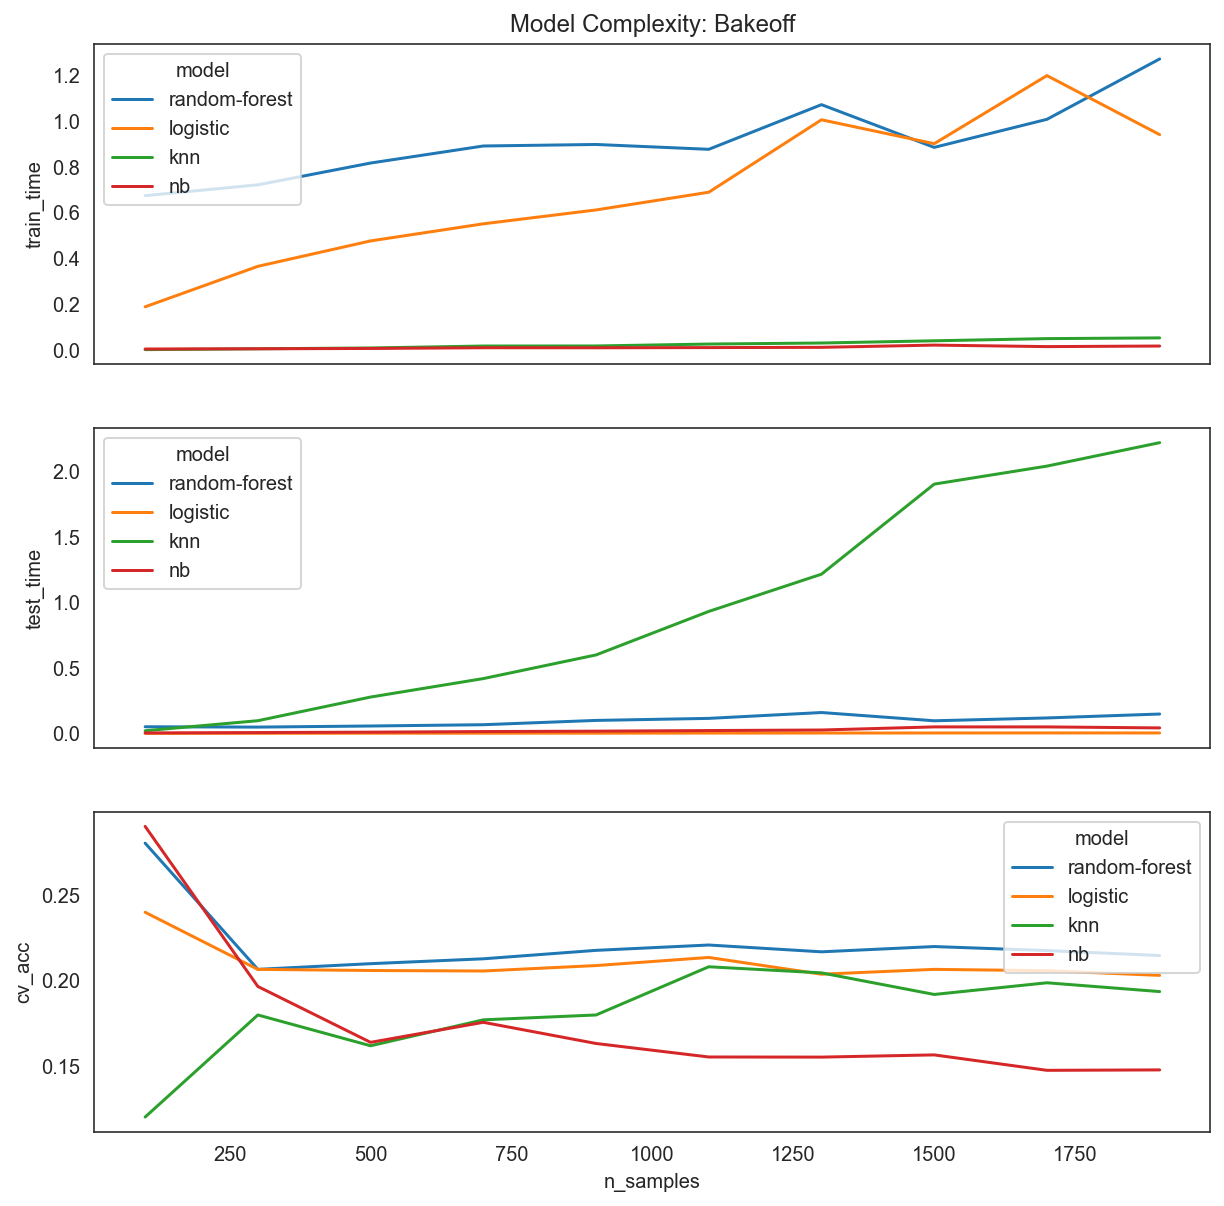

In [9]:
fig, axes = subplots(nrows=3, sharex=True, figsize=(10,10))

sns.lineplot(x="n_samples", y="train_time", hue="model", data=complexity_df, ax=axes[0])
sns.lineplot(x="n_samples", y="test_time", hue="model", data=complexity_df, ax=axes[1])
sns.lineplot(x="n_samples", y="cv_acc", hue="model", data=complexity_df, ax=axes[2])
axes[0].set_title("Model Complexity: Bakeoff")
savefig("imgs/bakeoff_all.png", dpi=200)

## Exercise

What do these results tell us about which models would be feasible to use in practice?

* When would selecting a model with **low train complexity** be a priority?
* When would selecting a model with **low test complexity** be a priority?

# Takeaways

What does this tell us? These analyses don't give us hard-and-fast answers. The instructors at Metis have decided to teach these models because every one of them is either important to understand or likely to be used in industry, and often both. 

Two of these in particular are worth noting: KNN and Random Forests. Both of these models are strong performers on benchmark tasks, where we have a fixed dataset and we want to see which model performs best (these are often derisively referred to as "bake offs").

But (as they are implemented in sklearn) they both have a weakness: Prediction time scales linearly with the number of examples in our training set. This is important because often *the only or easiest way to improve a model is to add more and better training data*. For these two, more data might lead to better predictions, but also leads to slower performance. You'll find that this is always true of KNN but you might be able to tweak the hyperparameters of Random Forests to get improved time complexity.

## Optional Exercise

Modify the above code block to benchmark models in terms of the number of features.

In [10]:
## Solution
num_loops = 5
num_repeats = 1
num_tests = 20
max_samples = 500
max_features = 784
max_sec = 30

# my favorite way to build a datafrom on the fly is 
# to start with a list of dictionaries
complexity_lod = []


# set up the list of the different sizes we want to try
features = np.linspace(50,max_features, num=num_tests, dtype=int)

model_dict = {
    "random-forest": ensemble.RandomForestClassifier(n_estimators=100),
    "logistic": linear_model.LogisticRegression(solver="lbfgs", multi_class="auto"),
    "knn": neighbors.KNeighborsClassifier(),
    "nb": naive_bayes.GaussianNB()
}


# loop through each training/test set size
for n_feat in features:
    print(f"Running for {n_feat} features. ", end="")
    lap_time = arrow.now()
    for model_key in model_dict:
        
        model = model_dict[model_key]
    
        # we take the min of the repeats because variation is likely due not to python execution 
        # but other operations https://docs.python.org/3/library/timeit.html#timeit.Timer.repeat
        train_time = np.min(
            timeit.repeat(
                f'model.fit(x[:max_samples,:n_feat],y[:max_samples])',
                globals=globals(),
                repeat=num_repeats,
                number=num_loops))

        test_time = np.min(
            timeit.repeat(
                f'model.predict(x[:max_samples,:n_feat])',
                globals=globals(),
                repeat=num_repeats,
                number=num_loops))

        complexity_lod.append({
                "model": model_key,
                "train_time": train_time,
                "test_time": test_time,
                "n_features": n_feat
            })
    print(f"Time: {(arrow.now() -lap_time).seconds} seconds.")
    if lap_time.shift(seconds=max_sec) < arrow.now():
        print("breaking")
        break
complexity_df = pd.DataFrame(complexity_lod)

Running for 50 features. Time: 1 seconds.
Running for 88 features. Time: 1 seconds.
Running for 127 features. Time: 1 seconds.
Running for 165 features. Time: 2 seconds.
Running for 204 features. Time: 3 seconds.
Running for 243 features. Time: 3 seconds.
Running for 281 features. Time: 3 seconds.
Running for 320 features. Time: 2 seconds.
Running for 359 features. Time: 4 seconds.
Running for 397 features. Time: 4 seconds.
Running for 436 features. Time: 3 seconds.
Running for 474 features. Time: 3 seconds.
Running for 513 features. Time: 3 seconds.
Running for 552 features. Time: 4 seconds.
Running for 590 features. Time: 4 seconds.
Running for 629 features. Time: 4 seconds.
Running for 668 features. Time: 4 seconds.
Running for 706 features. Time: 4 seconds.
Running for 745 features. Time: 4 seconds.
Running for 784 features. Time: 4 seconds.


<AxesSubplot:xlabel='n_features', ylabel='train_time'>

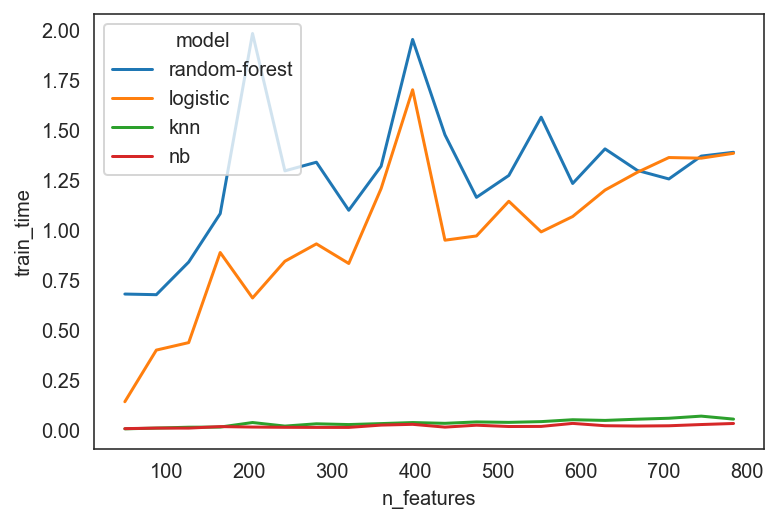

In [11]:
sns.lineplot(x="n_features", y="train_time", hue="model", data=complexity_df)

<AxesSubplot:xlabel='n_features', ylabel='test_time'>

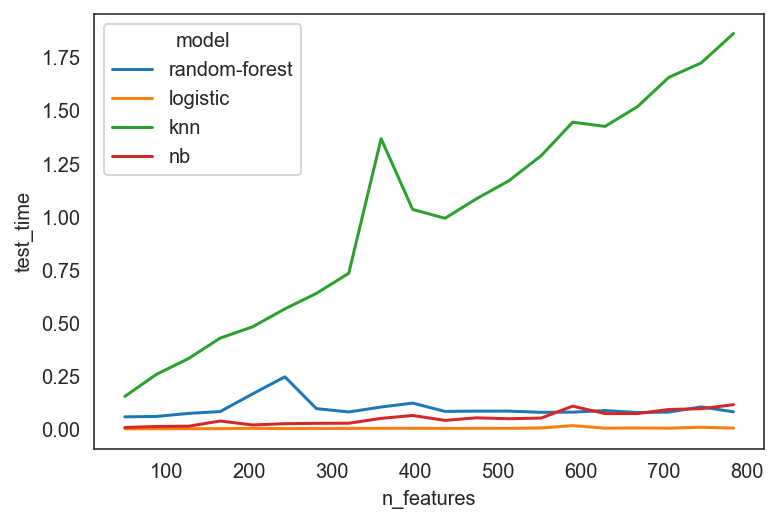

In [12]:
sns.lineplot(x="n_features", y="test_time", hue="model", data=complexity_df)